In [464]:
import pandas as pd
import time
import json
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [142]:
df = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels_updated/PRA_labels_with-graph-order_children_parents.csv')
df.head(2)

,id,name,parent_id,graph_order,children,has_children,parent_ids
0,0,NaN,root,0,"[443,444,445,446,448,450,451,452]",1,root
1,35,brainstem,449,2,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",1,0


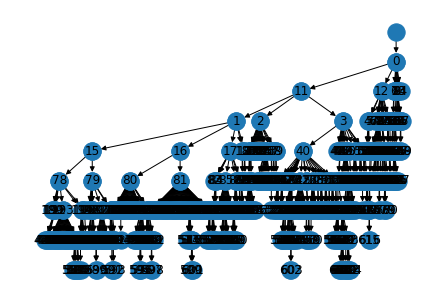

In [567]:
g = nx.DiGraph()

for index, row in df.iterrows():
    g.add_node(row.id,name=row.name)
    g.add_edge(row.parent_id,row.id)

labels = nx.get_node_attributes(g, 'name')
pos =graphviz_layout(g, prog='dot')
nx.draw(g, pos, with_labels=True,labels=labels, arrows=True)

In [639]:
def get_subgraph_by_head_node(g,num):
    vals = list(nx.ancestors(g,num))
    for val in vals:
        desc = list(nx.descendants(g,val))
        for dec in desc:
            if dec in g and dec != num:
                vals.append(dec)
            if str(dec) in g and dec != num:
                vals.append(str(dec))
    sg = g.copy()
    sg.remove_nodes_from(vals)
    return sg

Text(0.5, 1.0, 'all nodes and edges')

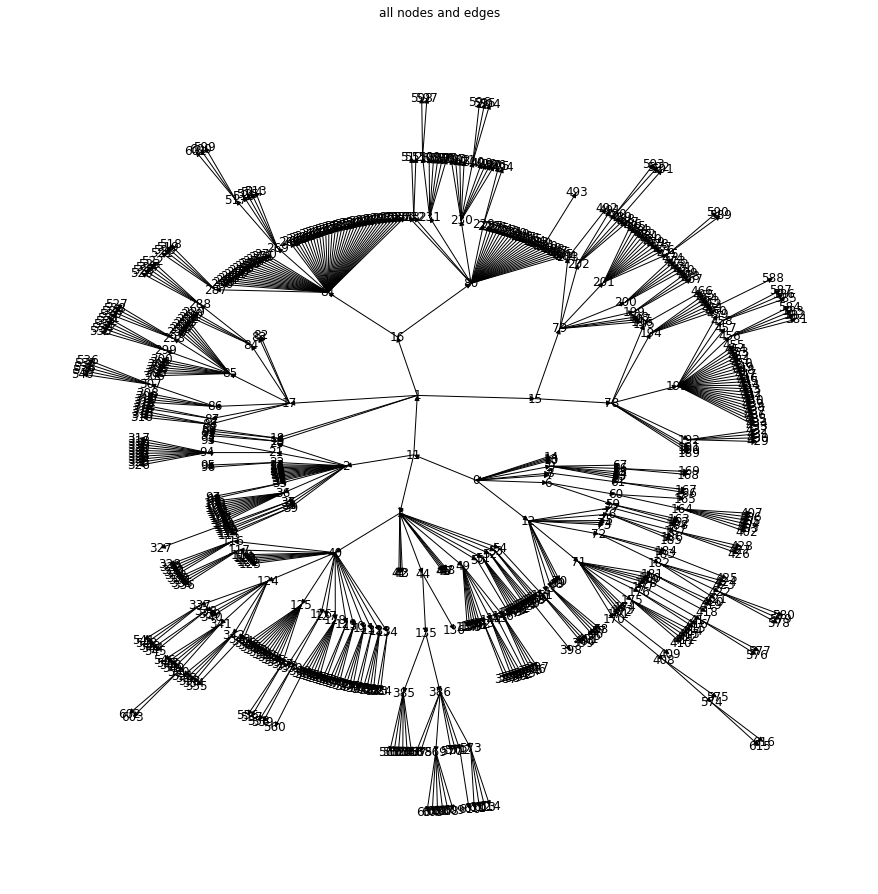

In [641]:
plt.figure(figsize=(12, 12))
labels=nx.get_node_attributes(g,'name')
pos = graphviz_layout(g, prog="twopi", args="")
nx.draw(g, pos, labels=labels,arrows=True,node_size=0)
plt.title('all nodes and edges')

Text(0.5, 1.0, 'subset by 449')

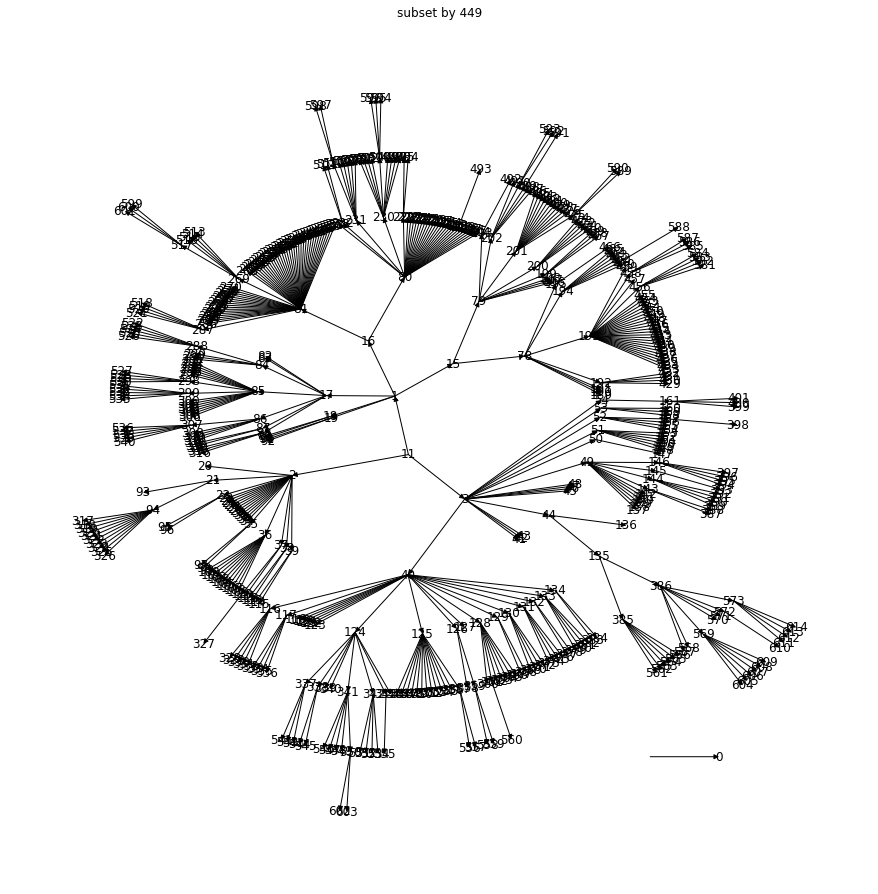

In [642]:
num=449
sg = get_subgraph_by_head_node(g,num)

plt.figure(figsize=(12, 12))
labels = nx.get_node_attributes(sg, 'name')

pos = graphviz_layout(sg, prog="twopi", args="")
nx.draw(sg, pos, labels=labels,arrows=True,node_size=0)
plt.title('subset by {}'.format(num))

In [643]:
nx.write_gexf(sg,'/Users/emilydennis/Desktop/lightsheet/pra_ingexf_subg.gexf')

In [698]:
for gg in sg:
    print(str(gg))

0
root
35
449
36
37
449
39
35
40
41
577
595
43
36
51
52
53
54
55
127
128
129
184
185
186
187
188
255
568
580
587
609
610
59
37
63
64
65
66
67
398
564
565
567
570
571
573
581
617
189
39
190
225
40
226
305
41
306
592
593
594
611
612
134
577
135
340
595
341
44
51
45
46
52
47
9
568
10
170
580
171
172
173
174
175
176
177
178
179
180
217
587
218
485
609
486
487
610
488
91
59
92
93
94
95
96
97
98
104
105
233
234
237
238
239
240
242
597
604
34
66
563
38
567
106
107
108
109
110
111
575
576
605
62
570
68
571
69
70
71
72
73
87
573
88
89
574
181
581
182
183
588
617
265
189
266
267
589
590
591
599
405
190
406
407
598
600
601
602
608
20
225
21
22
211
212
213
214
256
377
388
389
390
391
392
393
394
395
396
397
399
400
401
402
403
404
566
584
585
586
615
14
226
15
16
17
18
19
27
164
165
166
167
168
169
227
228
229
230
231
245
246
247
248
249
250
262
263
264
336
337
338
339
501
502
503
504
505
506
507
508
509
510
515
516
517
518
522
523
524
525
526
527
528
529
614
307
592
308
309
310
311
593
312
313
31

In [717]:
def find_roots(g):
    root=[]
    for gg in g:
        if gg != 'root':
            if len(sg.in_edges(int(gg))) < 1:
                root.append(gg)
    return root

In [718]:
roots = find_roots(sg)
roots

['449', 449]

In [741]:
def group_level_from_root(g,root,max_level):
    desc = list(nx.descendants(g,root))
    level=1
    for child in desc:
        if str(child) in g and len(nx.descendants(g,str(child))) > 0 and level < max_level:
            for grandchild in list(nx.descendants(g,str(child))):
                if str(grandchild) in g:
                    desc.append(str(grandchild))
            level+=1
    return desc

In [748]:
desc = group_level_from_root(sg,'449',3)

[35,
 36,
 37,
 '577',
 '39',
 '40',
 '41',
 '595',
 '580',
 '587',
 '609',
 '610',
 '51',
 '52',
 '568']